In [1]:
import numpy as np
import torch.nn as nn
import torch
import pytorch_lightning as pl
import cv2
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F

# Encoder 8

In [2]:
class Seg_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv=nn.Conv2d(3,768,kernel_size=16,stride=16)
        self.position=nn.Parameter(torch.randn(1,196,768))
        encoder_layer = nn.TransformerEncoderLayer(d_model=768, nhead=8, batch_first=True)
        self.transformer_model=nn.TransformerEncoder(encoder_layer, num_layers=8)
        self.up1=nn.Conv2d(768,256,kernel_size=3,padding=1)
        self.up2=nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.up3=nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.up4=nn.Conv2d(256,4,kernel_size=3,padding=1)
    def forward(self,x):
        x=self.conv(x)
        b,e,_,_=x.shape
        x=x.view(b,e,-1)
        x=x.permute(0,2,1)
        x=x+self.position
        x=self.transformer_model(x)
        b,seq,e=x.shape
        h,w=int(224/16),int(224/16)
        x=x.reshape(b,h,w,e)
        
        x=x.permute(0,3,1,2)
        
        x=nn.Upsample(scale_factor=2,mode='bilinear')(x)
        x=self.up1(x)
        
        x=nn.Upsample(scale_factor=2,mode='bilinear')(x)
        x=self.up2(x)
        
        x=nn.Upsample(scale_factor=2,mode='bilinear')(x)
        x=self.up3(x)
        
        x=nn.Upsample(scale_factor=2,mode='bilinear')(x)
        x=self.up4(x)
        
        return x

In [3]:
class Baby_skin(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model=Seg_Model()
        self.loss_fun=nn.CrossEntropyLoss()
        self.optimizer=torch.optim.Adam(self.model.parameters(),lr=1e-4)
        
    def forward(self,x):
        x=self.model(x)
        return x
    def training_step(self,batch,batch_index):
        img,mask=batch
        pred=self(img)
        mask=mask[:,0,:,:]
        
        loss=self.loss_fun(pred,mask)
        pred=torch.argmax(pred,dim=1)
        
        train_acc=(pred==mask).sum()/(mask.numel())
        
        self.log('Training_loss',loss)
        self.log('Training_acc',train_acc)
        return loss
        
    def validation_step(self,batch,batch_indx):
        img,mask=batch
        pred=self(img)
        mask=mask[:,0,:,:]
        
        loss=self.loss_fun(pred,mask)
        
        pred=torch.argmax(pred,dim=1)
        
        val_acc=(pred==mask).sum()/(mask.numel())
        
        self.log('Validation_loss',loss)
        self.log('Val_acc',val_acc)
        return loss
    
    def configure_optimizers(self):
        return [self.optimizer]

In [4]:
class decoder_seg(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.conv4=nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.conv5=nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.conv6=nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.conv7=nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.conv8=nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.conv9=nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.conv10=nn.Conv2d(64,4,kernel_size=3,padding=1)
        self.relu=nn.ReLU()

    def forward(self,x):
        x=F.interpolate(x, scale_factor=2)
        x=self.relu(self.conv1(x))
        x=self.relu(self.conv2(x))
        x=F.interpolate(x,scale_factor=2)
        x=self.relu(self.conv3(x))
        x=self.relu(self.conv4(x))
        x=F.interpolate(x,scale_factor=2)
        x=self.relu(self.conv5(x))
        x=self.relu(self.conv6(x))
        x=F.interpolate(x,scale_factor=2)
        x=self.relu(self.conv7(x))
        x=self.relu(self.conv8(x))
        x=F.interpolate(x,scale_factor=2)
        x=self.relu(self.conv9(x))
        x=self.conv10(x)
        
        return x
    

In [5]:
class Baby_skin(pl.LightningModule):
    def __init__(self):
        super().__init__()
        model=torchvision.models.vgg13(weights=torchvision.models.VGG13_Weights)
        self.encoder_seg=nn.Sequential(*list(model.children())[0])
        self.decoder_seg=decoder_seg()
        self.loss_fun=nn.CrossEntropyLoss()
        self.optimizer=torch.optim.Adam(self.decoder_seg.parameters(),lr=1e-4)
        
    def forward(self,x):
        x=self.encoder_seg(x)
        x=self.decoder_seg(x)
        return x
    def training_step(self,batch,batch_index):
        img,mask=batch
        pred=self(img)
        mask=mask[:,0,:,:]
        
        loss=self.loss_fun(pred,mask)
        pred=torch.argmax(pred,dim=1)
        
        train_acc=(pred==mask).sum()/(mask.numel())
        
        self.log('Training_loss',loss)
        self.log('Training_acc',train_acc)
        return loss
        
    def validation_step(self,batch,batch_indx):
        img,mask=batch
        pred=self(img)
        mask=mask[:,0,:,:]
        
        loss=self.loss_fun(pred,mask)
        
        pred=torch.argmax(pred,dim=1)
        
        val_acc=(pred==mask).sum()/(mask.numel())
        
        self.log('Validation_loss',loss)
        self.log('Val_acc',val_acc)
        return loss
    
    def configure_optimizers(self):
        return [self.optimizer]

In [6]:
model=Baby_skin.load_from_checkpoint(r'C:\Users\PhysioSens\Desktop\python-jupyter\ubfc_seg\mix\logs\lightning_logs\version_9\checkpoints\epoch=72-step=16352.ckpt')
model=model.to('cuda')
model=model.eval()

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG13_Weights.IMAGENET1K_V1`. You can also use `weights=VGG13_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def cuda_img(img):
    img=cv2.resize(img,(224,224))
    img=np.transpose(img,(2,0,1))
    img=img/255
    img=torch.tensor(img)
    img=img.float()
    img=img.unsqueeze(0)
    img=img.to('cuda')
    return img

def best_contour(contours):
    Area=[]
    for contour in contours:
        Area.append(cv2.contourArea(contour))
    return contours[np.argmax(Area)]
def view_img(img,mask):
    for i in range(1,4):
        new_mask=np.zeros_like(mask)
        new_mask[mask==i]=255
        new_mask=np.uint8(new_mask)
        new_mask=cv2.resize(new_mask,(640,480))
        contour,_=cv2.findContours(new_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        if len(contour)>1:
            contour=best_contour(contour)
            img=cv2.drawContours(img,[contour],-1,color[i],2)
        else:
            img=cv2.drawContours(img,contour,-1,color[i],2)
    return img

'''
def best_contour(contours):
    Area = [cv2.contourArea(contour) for contour in contours]
    return contours[np.argmax(Area)]



def view_img(img, mask):
    for i in range(1, 4):
        new_mask = np.zeros_like(mask)
        new_mask[mask == i] = 255
        new_mask = np.uint8(new_mask)
        new_mask = cv2.resize(new_mask, (640, 480))
        contours, _ = cv2.findContours(new_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours) > 1:
            contour = best_contour(contours)
            print('more than one', type(contour))
            img = cv2.drawContours(img, [contour], -1, color[i], 3)
        else:
            print(type(contours))
            img = cv2.drawContours(img, contours, -1, color[i], 3)
    return img
'''

"\ndef best_contour(contours):\n    Area = [cv2.contourArea(contour) for contour in contours]\n    return contours[np.argmax(Area)]\n\n\n\ndef view_img(img, mask):\n    for i in range(1, 4):\n        new_mask = np.zeros_like(mask)\n        new_mask[mask == i] = 255\n        new_mask = np.uint8(new_mask)\n        new_mask = cv2.resize(new_mask, (640, 480))\n        contours, _ = cv2.findContours(new_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\n        \n        if len(contours) > 1:\n            contour = best_contour(contours)\n            print('more than one', type(contour))\n            img = cv2.drawContours(img, [contour], -1, color[i], 3)\n        else:\n            print(type(contours))\n            img = cv2.drawContours(img, contours, -1, color[i], 3)\n    return img\n"

In [8]:
dic_label={'forehead':1,'left_cheek':2,'right_cheek':3}


In [9]:
color={1:(0,0,255),2:(255,0,0),3:(0,255,0),4:(255,255,0),5:(255,0,255),6:(0,255,255)}


In [10]:

v=cv2.VideoCapture(r'C:\Users\PhysioSens\Desktop\python-jupyter\ubfc_seg\aravind.avi')
while True:
    rect,frame=v.read()
    if rect==False:
        break
    #frame=cv2.resize(frame,(640,480))
    #frame=cv2.flip(frame,0)
    #frame=frame[:,:,::-1]
    img=cuda_img(frame)
    with torch.no_grad():
        pred=model(img)
    pred=pred[0].cpu().detach().numpy()
    pred=np.argmax(pred,axis=0)
    img_view=view_img(frame,pred)
    cv2.imshow('frame',img_view)
    key=cv2.waitKey(1)&0XFF
    if key==ord('q'):
        break
    if key==ord('a'):
        cv2.imwrite('mode_fist_1_mov.png',img_view)
v.release()
cv2.destroyAllWindows()


# with face-mesh

In [30]:
#pip install mediapipe
import cv2
import mediapipe as mp
import time
import matplotlib.pyplot as plt
import numpy as np


In [31]:
def view_img(img,mask):
    for i in range(1,4):
        new_mask=np.zeros_like(mask)
        new_mask[mask==i]=255
        new_mask=np.uint8(new_mask)
        new_mask=cv2.resize(new_mask,(640,480))
        contour,_=cv2.findContours(new_mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        if len(contour)>1:
            contour=best_contour(contour)
            img=cv2.drawContours(img,[contour],-1,color[i],cv2.FILLED)
        else:
            img=cv2.drawContours(img,contour,-1,color[i],cv2.FILLED)
    return img
def cuda_img(img):
    img=cv2.resize(img,(224,224))
    img=np.transpose(img,(2,0,1))
    img=img/255
    img=torch.tensor(img)
    img=img.float()
    img=img.unsqueeze(0)
    img=img.to('cuda')
    return img

def best_contour(contours):
    Area=[]
    for contour in contours:
        Area.append(cv2.contourArea(contour))
    return contours[np.argmax(Area)]


In [67]:
mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)
drawSpec = mpDraw.DrawingSpec(thickness=1, circle_radius=1,color=(0,128,0))
num1=[10]
num2=[50,280]
v=cv2.VideoCapture(r'C:\Users\PhysioSens\Desktop\python-jupyter\ubfc_seg\aravind.avi')
while True:
    rect,frame=v.read()
    if rect==False:
        break

    img=cuda_img(frame)
    with torch.no_grad():
        pred=model(img)
    
    pred=pred[0].cpu().detach().numpy()
    pred=np.argmax(pred,axis=0)
       
    #img_view=view_img(frame.copy(),pred)
    img_view=frame.copy()
    
    imgRGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = faceMesh.process(imgRGB)
    face=[]
    if results.multi_face_landmarks:
        for faceLms in results.multi_face_landmarks:
            for id,lm in enumerate(faceLms.landmark):
                ih, iw, ic = frame.shape
                x,y = int(lm.x*iw), int(lm.y*ih)
                face.append((x,y))
                if id in num1:
                    cv2.rectangle(img_view,(face[id][0]-60,face[id][1]-25),(face[id][0]+60,face[id][1]+25),(0,0,0),4)
                if id in num2:
                    cv2.rectangle(img_view,(face[id][0]-25,face[id][1]-25),(face[id][0]+25,face[id][1]+25),(0,0,0),4)
    else:
        print('no')
    cv2.imshow('frame',img_view)
    key=cv2.waitKey(1)&0XFF
    if key==ord('q'):
        break
    
    if key==ord('a'):
        cv2.imwrite('model_fist_mov.png',img_view)
v.release()
cv2.destroyAllWindows()


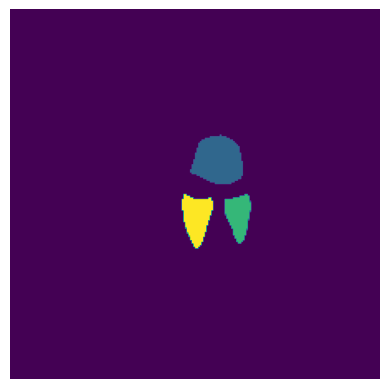

In [71]:
plt.imshow(pred)
plt.axis('off')
plt.savefig('model_mask.png')

In [22]:
cv2.destroyAllWindows()

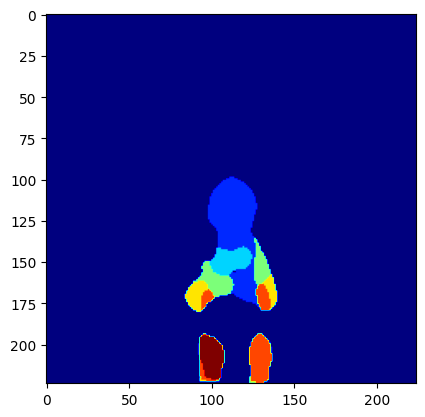

In [21]:
plt.imshow(pred,cmap='jet')

In [33]:
np.unique(pred)

array([  0,  40,  80, 120, 160, 200, 240], dtype=uint8)